In [ ]:
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1476960486273689545
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7546403488565965126
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#!unzip -q "/content/drive/My Drive/dataset/xrays.zip"
!mkdir xrays
!cp -r "/content/drive/My Drive/dataset/Test" "xrays/"
!cp -r "/content/drive/My Drive/dataset/Train" "xrays/"

cp: cannot stat '/content/drive/My Drive/dataset/Test': No such file or directory
cp: cannot stat '/content/drive/My Drive/dataset/Train': No such file or directory


In [ ]:
covid = os.listdir('/content/xrays/Train/covid/')

normal = os.listdir('/content/xrays/Train/normal/')

cov = pd.DataFrame(covid, columns=['name'])

nor = pd.DataFrame(normal, columns=['name'])

cov ['disease'] = 'covid'

nor ['disease'] = 'normal'

cov ['label'] = 0

nor ['label'] = 1

frames = [cov, nor]
datas = pd.concat(frames)

datas.sample(10)

,name,disease,label
15,cov 125.jpeg,covid,0
66,nor 20.jpeg,normal,1
55,cov 24.jpeg,covid,0
53,cov 89.jpeg,covid,0
92,nor 91.jpeg,normal,1
174,cov 81.jpeg,covid,0
65,nor 104.jpeg,normal,1
48,nor 108.jpeg,normal,1
19,nor 27.jpeg,normal,1
115,nor 31.jpeg,normal,1


In [ ]:
datas.index = range(len(datas))

datas.to_csv('info_datas.csv', index=False)

!mkdir train

!cp /content/xrays/Train/covid/* train/

!cp /content/xrays/Train/normal/* train/

In [ ]:
covid = os.listdir('/content/xrays/Test/covid/')

normal = os.listdir('/content/xrays/Test/normal/')

cov = pd.DataFrame(covid, columns=['name'])

nor = pd.DataFrame(normal, columns=['name'])

cov ['disease'] = 'covid'

nor ['disease'] = 'normal'

cov ['label'] = 0

nor ['label'] = 1

frames = [cov, nor]
datas = pd.concat(frames)

datas.sample(10)

,name,disease,label
32,nor 123.jpeg,normal,1
2,nor 97.jpeg,normal,1
26,cov 225.jpeg,covid,0
36,nor 145.jpeg,normal,1
37,cov 223.jpeg,covid,0
13,cov 212.jpeg,covid,0
24,cov 196.jpeg,covid,0
26,nor 116.jpeg,normal,1
35,cov 226.jpeg,covid,0
22,nor 120.jpeg,normal,1


In [ ]:
datas.index = range(len(datas))

datas.to_csv('info_test_datas.csv', index=False)

!mkdir test

!cp /content/xrays/Test/covid/* test/

!cp /content/xrays/Test/normal/* test/

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('generator.py','wb').write(src)
import generator

Saving generator1.py to generator1.py


Using TensorFlow backend.


In [ ]:
import keras
import generator
from keras.applications.densenet import DenseNet121
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from generator import DataGenerator

In [ ]:
input_shape = (224, 224, 3)
train_path = '/content/info_datas.csv'
test_path = '/content/info_test_datas.csv'
num_of_class = 1

In [ ]:
img_in = Input(input_shape)              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='avg') 

x = model.output  
predictions = Dense(num_of_class, activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
partition ={}

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

train_data.index =train_data.name
test_data.index =test_data.name

In [ ]:
X_train = train_data['label'].to_dict()
X_test = test_data['label'].to_dict()
partition = {'train':list(X_train.keys()), 'validation':list(X_test.keys()) }

In [ ]:
train_generator = DataGenerator(partition['train'], X_train,path = '/content/train/')
validation_generator = DataGenerator(partition['validation'], X_test, path='/content/test/')

In [ ]:
checkpoints=[]
checkpoints.append(keras.callbacks.ModelCheckpoint('test.h5',monitor='val_binary_accuracy',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1))

In [ ]:
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy])
history=model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers = 4,
                    epochs=1,
                    callbacks=checkpoints
                    )

Epoch 1/1
9/9 [==============================] - 77s 9s/step - loss: 0.0963 - binary_accuracy: 0.9618 - val_loss: 17.4960 - val_binary_accuracy: 0.5938


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with  val_binary_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


In [ ]:
model.save('model.h5')

NameError: ignored

In [ ]:
from shutil import copyfile
copyfile('/content/model.h5','/content/drive/My Drive/3classes/model7.h5')

'/content/drive/My Drive/3classes/model7.h5'

In [ ]:
import keras
model=keras.models.load_model('/content/drive/My Drive/3classes/model7.h5')
model.summary()

Using TensorFlow backend.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

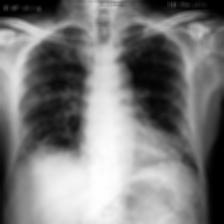

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('/content/test/cov 220.jpeg', 0)
cv2_imshow(img)

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image
image = load('/content/test/cov 220.jpeg')
pred=model.predict(image)
print(pred)
pred=model.predict(image)
arr=pred.tolist()
if (arr[0][0]<.5):
  print("covid")
else:
  print("normal")

[[0.20644218]]
covid


In [ ]:
test_data = pd.read_csv('/content/info_test_datas.csv')
index =test_data.name
target=test_data.label
test_index=np.asarray(index)
test_target=np.asarray(target)
result_array = np.array([])
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

for i in range(0,98):
  image = load('/content/test/'+test_index[i])
  pred=model.predict(image)
  #print(pred)
  arr=pred.tolist()
  print(i)
  print(test_index[i])
  if (test_target[i]==0):
    print("target: covid")
  else:
    print("target: normal")
  if (arr[0][0]<.5):
    print("prediction: covid")
    pos=0
  else:
    print("prediction: normal")
    pos=1

  result_array = np.append(result_array,pos)

In [ ]:
result_array=np.int_(result_array)

In [ ]:
test_target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
result_array

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_target,result_array)

array([[23, 23],
       [ 0, 52]])

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_target,result_array)

0.75

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_target,result_array))
confusion_matrix(test_target,result_array)
#pd.DataFrame(confusion_matrix(test_target,result_array)),columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        46
           1       0.69      1.00      0.82        52

    accuracy                           0.77        98
   macro avg       0.85      0.75      0.74        98
weighted avg       0.84      0.77      0.75        98



array([[23, 23],
       [ 0, 52]])

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(test_target,result_array)
#plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(test_target,result_array))
    
false_positives = 23
true_positives = 52
false_positive_rate = false_positives/46
true_positive_rate = true_positives/52
plt.scatter(false_positive_rate, true_positive_rate)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_target,result_array)

(array([1.        , 0.69333333]),
 array([0.5, 1. ]),
 array([0.66666667, 0.81889764]),
 array([46, 52]))

In [ ]:
print(precision_recall_fscore_support(test_target,result_array,average='binary'))

(0.6933333333333334, 1.0, 0.8188976377952756, None)


In [ ]:
from sklearn.metrics import f1_score
f1_score(test_target,result_array, average='binary')

0.8188976377952756

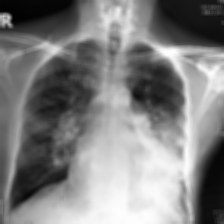

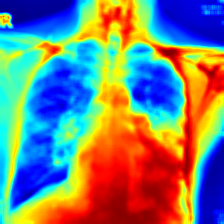

[[0.13084848]]
prediction: covid


In [ ]:
import cv2
from PIL import Image
import numpy as np
from skimage import transform
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/309_copy.jpg",0)
resized=cv2.resize(img,(224,224))
con = cv2.equalizeHist(resized)
dst = cv2.GaussianBlur(con,(5,5),cv2.BORDER_DEFAULT)
cv2_imshow(dst)
cv2.imwrite("trial1.jpg", dst) 
heatmap_img = cv2.applyColorMap(dst, cv2.COLORMAP_JET)
cv2_imshow(heatmap_img)

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image


image = load('/content/trial1.jpg')
pred=model.predict(image)
arr=pred.tolist()
print(pred)
if (arr[0][0]<.5):
  print("prediction: covid")
  pos=1
else:
  print("prediction: noncovid")
  pos=0